# Structured and time series data 

Based on the methodology taken by the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737). See fastai rossman.ipynb

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

Here we will use a Root Mean Square Error loss function to be consistent with other forecasting models used for this project

NB this notebook was divided into two parts

In this part we create and train a Neural Network


In [7]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [8]:
from fastai.structured import *
from fastai.column_data import *
import feather as ftr


In [9]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [10]:
PATH='../input/merged_data/'

In [11]:
from IPython.display import HTML, display

### Read in pre proc data

Pre-processed data generated in part a

In [12]:
DATA_NAME = 'current'
#DATA_NAME = 'last_week'

In [13]:
df = ftr.read_dataframe(f'{PATH}df_daily_cat_no_dates.feather')

In [14]:
#df.dtypes

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

In [15]:
#joined = pd.read_feather(f'{PATH}joined')
#joined_test = pd.read_feather(f'{PATH}joined_test')

In [16]:
#df.head().T.head(40)

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

### T/T split

In [17]:
df['day'].min()

Timestamp('2011-11-24 00:00:00')

In [18]:
df['day'].max()

Timestamp('2014-02-27 00:00:00')

One issue with this dataset is that the household meter measurements dont all start and end on the same date

Here we will use the period starting from 1/Feb/2014 as the test datset. Households which end memter measurements before the start of 1/Feb/2014 will be removed.

We will then use the period 1/Jan/2014 to 1/Feb/2014 as a validation dataset

In [19]:
split_date = pd.datetime(2014,2,1)

joined_train = df.loc[df['day'] <= split_date]
joined_test = df.loc[df['day'] > split_date]

In [20]:
len(df), len(joined_train), len(joined_test)

(3469352, 3339707, 129645)

In [21]:
#df_train.head(n=2)

In [22]:
cat_vars = ['dayWeek', 'dayYear', 'dayMonth', 'dayDay', 'dayDayofyear', 'stdorToU', 'Acorn', 'Acorn_grouped',
            'icon', 'precipType', 'summary']

contin_vars = ['energy_median','energy_mean','energy_max','energy_count',
               'energy_std','energy_sum','energy_min','temperatureMax',
               'windBearing','dewPoint','cloudCover','windSpeed','pressure',
               'apparentTemperatureHigh','visibility','humidity','apparentTemperatureLow',
               'apparentTemperatureMax','uvIndex','temperatureLow','temperatureMin',
               'temperatureHigh','apparentTemperatureMin','moonPhase','dayElapsed','daylightMins']

len(joined_train)

3339707

Convert MAC codes to integer 

In [23]:
joined_train['LCLid'] = joined_train['LCLid'].map(lambda x: str(x)[3:]).astype('int32')
joined_test['LCLid'] = joined_test['LCLid'].map(lambda x: str(x)[3:]).astype('int32')

In [24]:
energy_sum = joined_train['energy_sum'].values
dep = 'energy_sum'
#here 'energy_sum' becomes a df not a series - I use workaround below for
joined_train = joined_train[cat_vars+contin_vars+[dep, 'day']].copy()
joined_train.drop(columns=[dep],inplace=True)
joined_train[dep]=energy_sum
print(f"post vals train dep: {type(joined_train[dep])}")

post vals train dep: <class 'pandas.core.series.Series'>


In [25]:
#same for test
joined_test = joined_test[cat_vars+contin_vars+[dep, 'day','LCLid']].copy()
joined_test.drop(columns=[dep],inplace=True)
joined_test[dep] = 0
print(f"post vals test dep: {type(joined_test[dep])}")

post vals test dep: <class 'pandas.core.series.Series'>


In [27]:
joined_test.head(n=2)

,dayWeek,dayYear,dayMonth,dayDay,dayDayofyear,stdorToU,Acorn,Acorn_grouped,icon,precipType,summary,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_min,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,dayElapsed,daylightMins,day,LCLid,energy_sum
0,9,2014,2,27,58,Std,ACORN-A,Affluent,partly-cloudy-day,rain,Partly cloudy until evening.,0.2180,0.427458,1.350,48,0.406681,0.080,10.31,224,3.08,0.32,4.14,1007.02,10.31,12.04,0.74,0.82,10.31,2.0,3.43,3.93,10.31,1.41,0.93,1393459200,645.0,2014-02-27,2,0
1,9,2014,2,26,57,Std,ACORN-A,Affluent,partly-cloudy-day,rain,Partly cloudy throughout the day.,0.1515,0.256833,1.028,48,0.196095,0.076,11.29,227,2.74,0.26,3.82,1012.73,11.29,13.00,0.73,3.03,11.29,2.0,6.01,4.17,11.29,1.67,0.90,1393372800,641.0,2014-02-26,2,0


In [28]:
#for v in cat_vars: df_train[v] = df_train[v].astype('category').cat.as_ordered()
for v in cat_vars: 
    print(v)
    joined_train[v] = joined_train[v].astype('category').cat.as_ordered()

dayWeek
dayYear
dayMonth
dayDay
dayDayofyear
stdorToU
Acorn
Acorn_grouped
icon
precipType
summary


In [29]:
joined_train.head(n=2)

,dayWeek,dayYear,dayMonth,dayDay,dayDayofyear,stdorToU,Acorn,Acorn_grouped,icon,precipType,summary,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_min,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,dayElapsed,daylightMins,day,energy_sum
26,5,2014,2,1,32,Std,ACORN-A,Affluent,wind,rain,Partly cloudy until evening and breezy overnight.,0.13,0.238021,0.799,48,0.195760,0.076,9.72,217,3.18,0.19,6.97,990.08,4.27,11.60,0.76,2.81,6.86,1.0,6.24,4.83,8.32,1.10,0.06,1391212800,549.0,2014-02-01,11.425
27,5,2014,1,31,31,Std,ACORN-A,Affluent,wind,rain,Overcast throughout the day and breezy startin...,0.39,0.449458,1.627,48,0.443706,0.075,8.83,177,3.93,0.73,4.74,998.51,3.13,7.08,0.91,1.10,5.27,1.0,4.83,1.97,7.08,0.29,0.03,1391126400,546.0,2014-01-31,21.574


In [30]:
#alternatively we could just add df_test to the category re-declaration loop above
apply_cats(joined_test, joined_train)

In [31]:
for v in contin_vars:
    joined_train[v] = joined_train[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

We're going to run on a sample.

In [32]:
#idxs = get_cv_idxs(n, val_pct=150000/n)
#df_samp = df_train.iloc[idxs].set_index("day")
#samp_size = len(df_samp); samp_size

To run on the full dataset, use this instead:

In [33]:
#use this to create mapper - note we use the train df
samp_size = len(joined_train)
joined_samp = joined_train.set_index("day")

We can now process our data...

In [34]:
#keep track of the mapper (44:15)
#can set ignore_flds

In [35]:
df, y, nas, mapper = proc_df(joined_samp, 'energy_sum', do_scale=True)
print(f'first n y for df_samp: {y[:10]}')

first n y for df_samp: [11.425 21.574 14.166 20.304 13.921 22.629 24.04  14.039 14.54  12.585]


In [36]:
df.head(2)

,dayWeek,dayYear,dayMonth,dayDay,dayDayofyear,stdorToU,Acorn,Acorn_grouped,icon,precipType,summary,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_min,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,dayElapsed,daylightMins
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-01,5,4,2,1,32,1,2,4,6,1,77,-0.166119,0.142706,-0.052468,0.0,0.156232,0.199564,-0.692796,0.249180,-0.769030,-1.511314,2.091405,-2.296195,-1.173198,0.140441,-0.202914,-0.633878,-0.888970,-0.907385,-0.396777,-0.613610,-0.873035,-0.848323,-1.537353,1.711714,-0.958303
2014-01-31,5,4,1,31,31,1,2,4,6,1,56,1.373648,1.257727,1.189595,0.0,1.781616,0.187740,-0.827503,-0.192546,-0.620598,1.294841,0.738313,-1.470642,-1.320222,-1.774337,1.321910,-0.903980,-1.099264,-0.907385,-0.672921,-1.169821,-1.058100,-0.975675,-1.641443,1.706405,-0.974467


In [37]:
joined_test = joined_test.set_index("day")

In [38]:
#apply the same mapper to the test set

In [39]:
df_test, _, nas, mapper = proc_df(joined_test, 'energy_sum', do_scale=True, skip_flds=['LCLid'],
                                  mapper=mapper, na_dict=nas)

In [40]:
df.head(n=2)

,dayWeek,dayYear,dayMonth,dayDay,dayDayofyear,stdorToU,Acorn,Acorn_grouped,icon,precipType,summary,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_min,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,dayElapsed,daylightMins
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-01,5,4,2,1,32,1,2,4,6,1,77,-0.166119,0.142706,-0.052468,0.0,0.156232,0.199564,-0.692796,0.249180,-0.769030,-1.511314,2.091405,-2.296195,-1.173198,0.140441,-0.202914,-0.633878,-0.888970,-0.907385,-0.396777,-0.613610,-0.873035,-0.848323,-1.537353,1.711714,-0.958303
2014-01-31,5,4,1,31,31,1,2,4,6,1,56,1.373648,1.257727,1.189595,0.0,1.781616,0.187740,-0.827503,-0.192546,-0.620598,1.294841,0.738313,-1.470642,-1.320222,-1.774337,1.321910,-0.903980,-1.099264,-0.907385,-0.672921,-1.169821,-1.058100,-0.975675,-1.641443,1.706405,-0.974467


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on the fastai web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [41]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio)
val_idx = list(range(train_size, len(df)))

In [42]:
print(f'samp_size: {samp_size}')
print(f'train_ratio: {train_ratio}')
print(f'train_size: {train_size}')
print(f'len(df): {len(df)}')
print(f'val_idx: {len(val_idx)}')

samp_size: 3339707
train_ratio: 0.75
train_size: 2504780
len(df): 3339707
val_idx: 834927


In [43]:
val_idx[:10]

[2504780,
 2504781,
 2504782,
 2504783,
 2504784,
 2504785,
 2504786,
 2504787,
 2504788,
 2504789]

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [44]:
#val_idx = np.flatnonzero(
#    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [45]:
#val_idx=[0]

## DL

We're ready to put together our models.

Root-mean-squared error is the metric we used for other forecast models.

In [46]:
def rmse(y_pred, y_targ):
    return np.sqrt(((y_targ - y_pred) ** 2).mean())

#use 20% greater than biggest max seen in training data
max_y = np.max(y)
y_range = (0, max_y*1.2)

We can create a ModelData object directly from out data frame.

pass in the test dataframe in the usual way

In [47]:
print(f'pre cmd, val_idx: {len(val_idx)}')
print(f'df: {len(df)}')
print(f'y: {len(y)}')
print(f'cat_vars: {len(cat_vars)}')
print(f'df_test: {len(df_test)}')

pre cmd, val_idx: 834927
df: 3339707
y: 3339707
cat_vars: 11
df_test: 129645


In [48]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Check levels of categorical variables

In [50]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [51]:
cat_sz

[('dayWeek', 53),
 ('dayYear', 5),
 ('dayMonth', 13),
 ('dayDay', 32),
 ('dayDayofyear', 367),
 ('stdorToU', 3),
 ('Acorn', 20),
 ('Acorn_grouped', 6),
 ('icon', 7),
 ('precipType', 3),
 ('summary', 83)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [52]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [53]:
emb_szs

[(53, 27),
 (5, 3),
 (13, 7),
 (32, 16),
 (367, 50),
 (3, 2),
 (20, 10),
 (6, 3),
 (7, 4),
 (3, 2),
 (83, 42)]

In [54]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 27]),
                           ('trainable', True),
                           ('nb_params', 1431)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 3]),
                           ('trainable', True),
                           ('nb_params', 15)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', 91)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 16]),
                           ('trainable', True),
                           ('nb_params', 512)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1

In [55]:
#lr = 1e-3
lr = 2e-5
m.lr_find()

 28%|██▊       | 5563/19569 [00:41<01:44, 133.41it/s, loss=17.4]

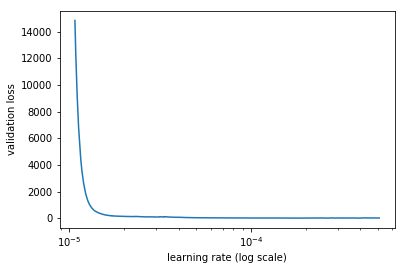

In [56]:
m.sched.plot(100)

### Sample

In [57]:
#m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
#                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
#lr = 1e-3

In [58]:
#m.fit(lr, 3, metrics=[rmse])

In [59]:
#m.fit(lr, 5, metrics=[rmse], cycle_len=1)

In [60]:
#m.fit(lr, 2, metrics=[rmse], cycle_len=4)

### All

In [61]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
#lr = 1e-3
lr = 2e-5

In [62]:
m.fit(lr, 1, metrics=[rmse])

epoch      trn_loss   val_loss   rmse       
    0      1.166705   0.890098   0.753684  


[array([0.8901]), 0.7536842124751327]

In [ ]:
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse       
    0      1.168089   1.473121   1.006735  
 56%|█████▌    | 10941/19569 [01:22<01:05, 132.23it/s, loss=0.416]

In [ ]:
m.fit(lr, 3, metrics=[rmse], cycle_len=1)

### Test

In [ ]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [ ]:
m.fit(lr, 3, metrics=[rmse])

In [ ]:
m.fit(lr, 3, metrics=[rmse], cycle_len=1)

In [ ]:
m.save('val0')

In [ ]:
m.load('val0')

In [ ]:
x,y=m.predict_with_targs()

In [ ]:
x[:10]

In [ ]:
y[:10]

In [ ]:
rmse(x,y)

In [ ]:
pred_test=m.predict(True)

In [ ]:
pred_test[:10]

In [ ]:
joined_test['energy_sum']=pred_test

In [ ]:
joined_test.head(n=2)

In [ ]:
csv_fn=f'{PATH}tmp/4_6_forecast_NN_preds.csv'

In [ ]:
joined_test[['LCLid','energy_sum']].to_csv(csv_fn, index=False)

## RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [ ]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [ ]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, rmse(preds, y_val)

## Reality check

We are not going to have 'energy_median','energy_mean','energy_max','energy_count', 'energy_std', 'energy_min' for day for the 7 day forecast - lets feed in 7 day historal data for the attempted prediction of 'energy_sum'

(we will have 7 day look ahead forecasts though so will leave in forecast data)

In [ ]:
df = ftr.read_dataframe(f'{PATH}df_week_delayed_daily_cat_no_dates.feather')